In [6]:
from fastai.vision.all import *
import torchvision
set_seed(42, True)
path=Path("/kaggle/input/fvc2000-vcs-rehalf/dataset_ori")
files=get_image_files(path)
# import wandb
# wandb.login(key='1b23517e0f9e52312f9554d602fdf4de1b98a8f4')
def halftone(img):
    if isinstance(img, PILImage):
        img1=img.convert("1").convert("L")
        return img1
    else:
        return img
    
def gray(img):
    if isinstance(img, PILImage):
        img1=img.convert("L")
        return img1
    else:
        return img

In [7]:
import os

dir_path = "/kaggle/input/fvc2000-vcs-rehalf/dataset_ori"
dir_names = [name for name in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, name))]
label_to_num = {label: num for num, label in enumerate(dir_names)}

In [8]:
len(dir_names)

10

In [9]:
# 定义label_func函数
def label_func(filepath):
    return filepath.parent.name

class TripletImage(fastuple):
    def show(self, loss=None, pred=None, p=None, ctx=None, **kwargs): 
        if len(self) > 3:
                img1,img2,img3,similarity = self
        else:
            img1,img2,img3 = self
            similarity = 'Undetermined'
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            if img3.size != img1.size: img3 = img3.resize(img1.size)
            t1,t2,t3 = tensor(img1),tensor(img2), tensor(img3)
            t1,t2,t3 = t1.permute(2,0,1),t2.permute(2,0,1),t3.permute(2,0,1)
        else: t1,t2,t3 = img1,img2,img3
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        if loss == None:
            return show_image(torch.cat([t2,line,t1,line,t3], dim=2), title=similarity, ctx=ctx, **kwargs)
        elif pred == None:
            return show_image(torch.cat([t2,line,t1,line,t3], dim=2), title=f"{loss:.2f}", ctx=ctx, **kwargs)
        return show_image(torch.cat([t2,line,t1,line,t3], dim=2), title=f"{pred}/{similarity} {loss:.2f} / {p:.2f}", ctx=ctx, **kwargs)

class TripletTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(get_image_files(path/l)) for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2, f3, anchor = self.valid.get(f, self._draw(f,0))
        img1,img2,img3 = PILImage.create(f),PILImage.create(f2),PILImage.create(f3)
        return TripletImage(img1, img2, img3, int(label_to_num[anchor]))
    
    def _draw(self, f, split=0):
        cls1 = label_func(f)
        cls2 = random.choice(L(l for l in labels if l != cls1))
        while len(self.lbl2files[cls2]) == 0: 
            cls2 = random.choice(L(l for l in labels if l != cls1))
        return random.choice(self.lbl2files[cls1]),random.choice(self.lbl2files[cls2]),cls1
    
@typedispatch
def show_batch(x:TripletImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): TripletImage(x[0][i], x[1][i], x[2][i], x[3][i]).show(ctx=ctx)
    
splits = RandomSplitter(seed=42)(files)
labels = list(set(files.map(label_func)))
tfm = TripletTransform(files, parent_label, splits)
tls = TfmdLists(files, tfm, splits=splits)

dls = tls.dataloaders(after_item=[Resize(160), ToTensor], 
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

#*aug_transforms()
class TripletModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    def forward(self, x1, x2, x3):
        x1 = self.encoder(x1)
        x2 = self.encoder(x2)
        x3 = self.encoder(x3)
        ftrs = torch.cat([x1, x2, x3], dim=1)
#         x1 = self.head(x1)
#         x2 = self.head(x2)
#         x3 = self.head(x3)
#         return x1, x2, x3
        return self.head(ftrs)

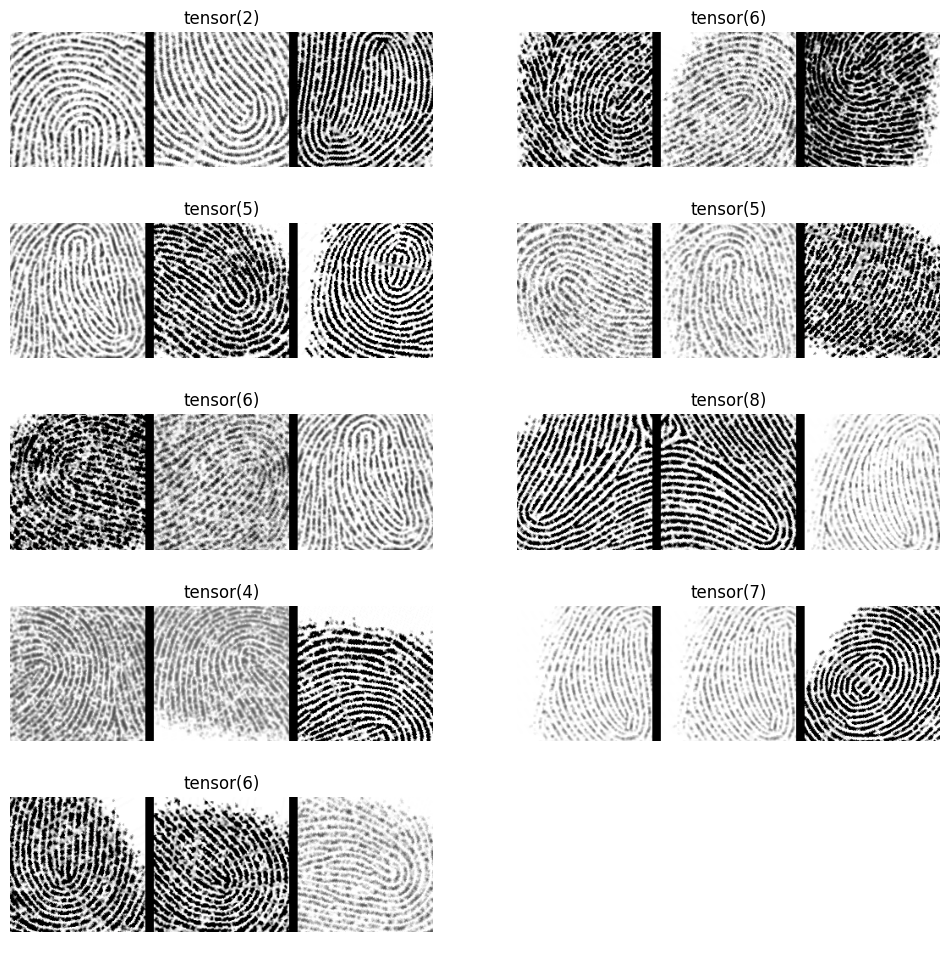

In [10]:
dls.show_batch()

In [11]:
EffNet=mobilenet_v2(weights="DEFAULT")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = create_body(EffNet, cut=-1)
head = create_head(1280*3, 10, [1024,128], ps=0.5)
model = TripletModel(encoder, head)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 133MB/s]


In [12]:
def triplet_splitter(model):
    return [params(model.encoder), params(model.head)]

In [13]:
# learn = Learner(dls, model, loss_func=triplet_loss_func(margin=1.00), opt_func=Adam,
#                 splitter=triplet_splitter, metrics=[accuracy,precison,recall,f1_score],
#                 cbs=[PrintBestThreshold()])

In [14]:
learn = Learner(
    dls, 
    model, 
    loss_func=CrossEntropyLossFlat(), 
    splitter=triplet_splitter, 
    metrics=[accuracy, Precision(average='macro'), Recall(average='macro'), F1Score(average='macro'),RocAuc (average='macro')],
    cbs=[ShowGraphCallback, SaveModelCallback]
)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.911966,0.206283,0.934375,0.936311,0.929638,0.929362,0.995708,00:09
1,0.468901,0.071959,0.962500,0.961868,0.958606,0.959688,0.999378,00:07
2,0.288564,0.039303,0.993750,0.993398,0.994286,0.993702,0.999955,00:07


Better model found at epoch 0 with valid_loss value: 0.20628342032432556.


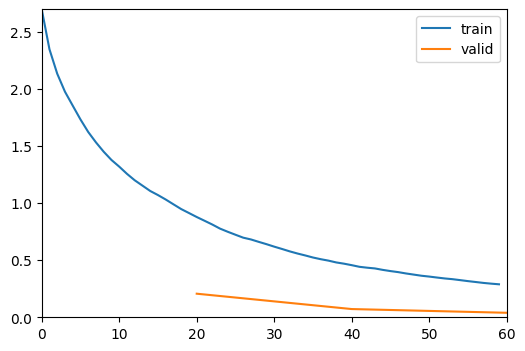

Better model found at epoch 1 with valid_loss value: 0.07195945829153061.
Better model found at epoch 2 with valid_loss value: 0.03930347412824631.


In [15]:
learn.freeze()
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.065978,0.024663,0.993750,0.993103,0.993695,0.993225,0.999962,00:08
1,0.051728,0.015205,0.996875,0.996429,0.997143,0.996733,1.000000,00:08
2,0.039283,0.009372,1.000000,1.000000,1.000000,1.000000,1.000000,00:08


Better model found at epoch 0 with valid_loss value: 0.024663349613547325.


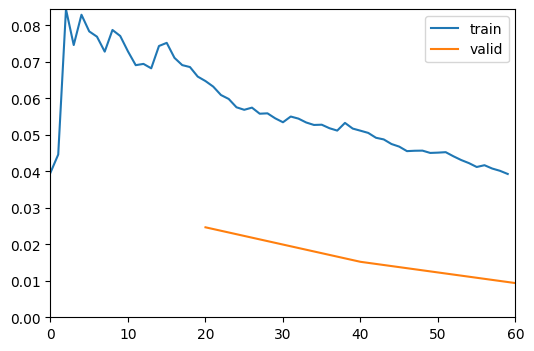

Better model found at epoch 1 with valid_loss value: 0.015205005183815956.
Better model found at epoch 2 with valid_loss value: 0.009371697902679443.


In [16]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-5,1e-3))

In [17]:
@typedispatch
def show_results(x:TripletImage, y, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        title = f'Actual: {[x[3][i].item()]} \n Prediction: {[y[3][i].item()]}'
        TripletImage(x[0][i], x[1][i], x[2][i], title).show(ctx=ctx)

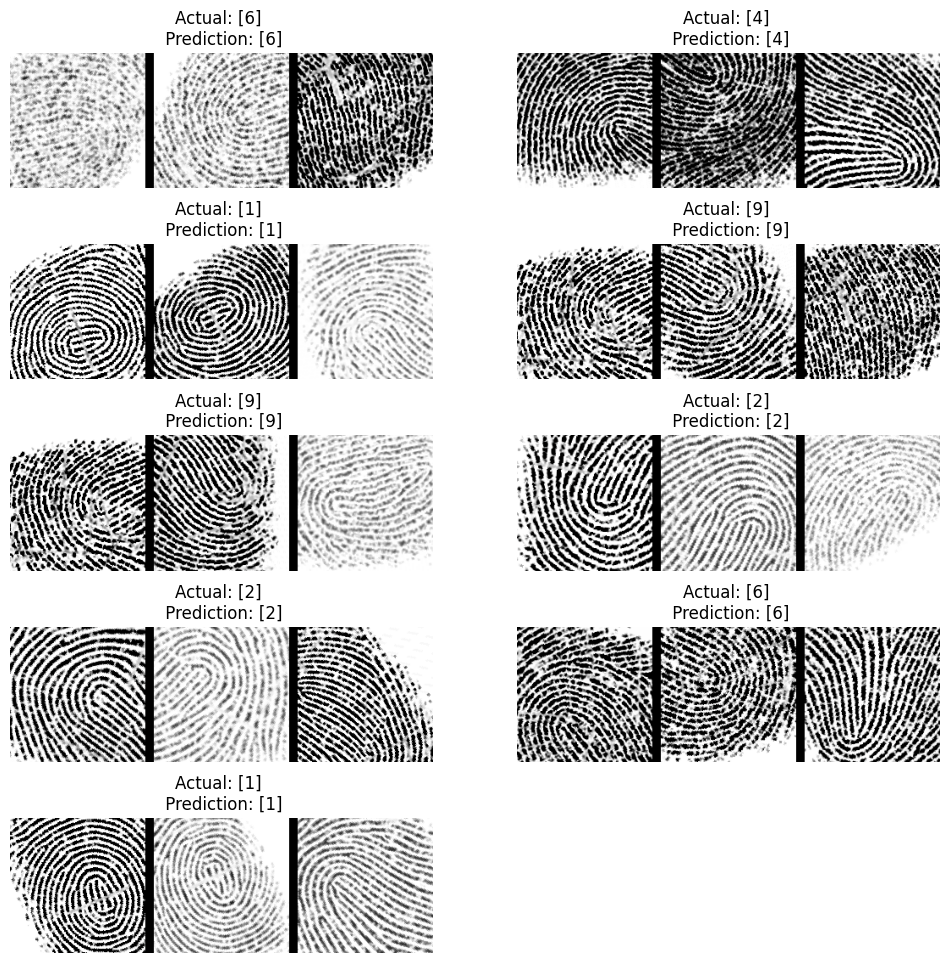

In [18]:
learn.show_results()

In [ ]:
tsne = TSNE(n_components=2)
output = tsne.fit_transform(ftrs.cpu().detach().numpy())
for i in range(len(output)):
    plt.plot(output[i, 0], output[i, 1], '.')

In [ ]:
learn.export('mobilenet_v2_Tri_Ori.pkl')
#learn = load_learner('.pkl', cpu=False)